# The Data Analysis Summary

This summary is used to analyze the relation between users and songs in certain years. We first use PANDAS to see the features and the number of observations in the data:

In [2]:
import pandas as pd
import numpy as np
usersData = pd.read_csv('data_sample/user_data_sample.csv')
print (usersData.shape)
usersData.head()

(9565, 5)


,gender,age_range,country,acct_age_weeks,user_id
0,male,25 - 29,FR,329,97f47c9fba714ca68320b8a80e010a1a
1,female,45 - 54,US,178,d615ca85849d458e9a5d755ec4727e8f
2,female,18 - 24,DE,68,6c83a5bf63b74f85b106ac7e7e015a1b
3,female,30 - 34,US,8,530fcedb3f244e6f91ecb326740005eb
4,female,30 - 34,FR,42,d2ed6a815eda4f61aa346b7936d03ef7


In [3]:
songsData = pd.read_csv('data_sample/end_song_sample.csv')
print (songsData.shape)
songsData.head()

(1342891, 6)


,ms_played,context,track_id,product,end_timestamp,user_id
0,330962,album,2ab4f3b3a6c34fbaba95c2451b65efbd,open,1.444790e+09,a9abbb14c8544898a0e06feb94f8051e
1,7476,album,0f5f2acbcf244490948ac2e63adade73,open,1.444790e+09,a9abbb14c8544898a0e06feb94f8051e
2,227280,collection,0f4a2173eb1f4aa9b8693ad7a92fab73,open,1.444797e+09,a9abbb14c8544898a0e06feb94f8051e
3,325,playlist,affc7467b68e4dfab9d1d7b9ec8d4673,open,1.444796e+09,a9abbb14c8544898a0e06feb94f8051e
4,204196,collection,427fd37cbfe640a8a78179477c9f33d3,open,1.444799e+09,a9abbb14c8544898a0e06feb94f8051e


In [4]:
songsData[songsData['ms_played']==0].shape

(61267, 6)

The data include 9,565 users and 1,342,891 songs (but 61,267 of them have no played time). In the "userData", each user has information of gender, age, country etc. The "songsData" has the played record for each song, "ms_played": listen time in milliseconds, "product": "=open" means free and "=premium" means paid, and the users' ID. We can combine these data and analyze the customers' habits. For exmaple, for the users on the certain gender and age, e.g. female and '25-29', how many times in average did they visit to listen the music list and pay? how much time in average did they listen music totally and pad? Do the observations reply on the countries?

In the followings, I will analyze the relation between the users' genders, ages and countries, and the time they spent on listening music with/without paying. The summary mainly includes three parts:

> (A) The codes

>        1) The production code to define the methods of MusicData class

>        2) The plot functions used in this summary 

>        3) P-value and SED functions

> (B) Users' data analysis

>        1) The users' habits on different genders: male and female

>        2) The users' habits on different ages

>        3) The users' habits on different countries

>        4) Clustering

> (C) Songs' data analysis

> (D) Summary

>  Appendix

## (A) The codes 

The codes section defines the "MusicData" class, plot functions and statistic and other functions used in the report.

### 1) The code to define the methods of MusicData class 

The following production code generates a class called "MusicData". The methods include:

O.users['user ID'] = [ender, age_range, country, acct_age_weeks, user_id]
O.songs['Song's name'] = [[user1, user2, user3 ....], time, paid time]

O.age['0 - 17'] = [user1, user2, user3 ....]  shows the users in the age of '0-17' group
O.country['US'] = [user1, user2, user3 ....]  shows the users in the country grup of 'US'
O.gender['male'] = number of users in the 'male' group

O.users_listen['user ID'] = [count, time]; "count": the number of time the user visited, 
                                           "time":  the total time length the user spent to listen
                                      
O.users_listen_pay['user ID'] = [paid_count, paid_time]; 
                                         "paid_count": number of time the user visited with payment, 
                                         "paid_time" the time length the user paid to listen


In [5]:
'''
    SongsData.py
    Module that cures something fantastic.
    @Author: Hsiang-Hsuan Hung
'''
class MusicData(object):
    '''Songs and users class'''
    def __init__(self):
        self.users = dict()
        self.songs = dict()
        
        self.age  = dict()
        self.country = dict()

        self.users_listen = dict()
        self.users_listen_pay = dict()
        self.gender = dict()


    def create_users_dict(self, input_usersfile):
        ''' prepare the users' info dictionary
            "self.users[John]" = [male, 25-30, US...] showing user John's info'''
        input_file = open(input_usersfile).readlines()
        input_file.pop(0)
        for user in input_file:
            user = user.replace('\n', '').split(',')
            if user[4] not in self.users:
                self.users[user[4]] = user[0:4]
                self.users_listen[user[4]] = [0, 0]
                self.users_listen_pay[user[4]] = [0, 0]
            # also preparing the users' age list, self.age['25-30'] = [John, Joe, ....]
            if user[1] not in self.age:
                self.age[user[1]] = [user[4]]
            else:
                self.age[user[1]].append(user[4])
            # also preparing users' country list, self.country['US'] = [John, Kevin, ....]               
            if user[2] not in self.country:
                self.country[user[2]] = [user[4]]
            else:
                self.country[user[2]].append(user[4])       

                
    def create_listen_dict(self, input_songsfile):
        ''' prepare the dictionary for the users "John" whose listneing time and count
             "self.users_listen[John][0]" showing how many times John listened totally,
             "self.users_listen[John][1]" showing the time length John's listened totally,
             "self.users_listen_pay[John][0]" showing how many times John paid to listen.
             "self.users_listen_pay[John][1]" showing John's paid listening time length.'''
        input_file = open(input_songsfile).readlines()
        input_file.pop(0) 
        for song in input_file:
            song = song.replace('\n', '').split(',')
            user = song[5]
            if int(song[0]) !=0: self.users_listen[user][0] += 1
            self.users_listen[user][1] += int(song[0])
            if song[3] == 'premium':
                self.users_listen_pay[user][0] += 1
                self.users_listen_pay[user][1] += int(song[0])  


    def create_song_users_dict(self, input_songsfile):
        ''' prepare the song dictionary who have listened the song:
         "self.songs[X]" = [[A,B,C...], b, c]:
          [A, B, C,...] are users who listened the song X,
          b is the total listen time length and c is the paid listening time length'''
        input_file = open(input_songsfile).readlines()
        input_file.pop(0)
        for song in input_file:
            song = song.replace('\n', '').split(',')
            if song[2] != '' and int(song[0]) != 0:  ## <- to avoid some songs' names are empty or played time =0
                listen_time = int(song[0])/1000/60
                paid_time = 0
                if song[3] == 'premium': paid_time = listen_time
                if song[2] not in self.songs:
                    self.songs[song[2]] = [[song[5]], listen_time, paid_time]
                else:
                    self.songs[song[2]][0].append(song[5])
                    self.songs[song[2]][1] += listen_time
                    self.songs[song[2]][2] += paid_time
                    #self.songs[song[2]][3] += float(song[4])

#   --------------------------------------------------------
#   --------------------------------------------------------
    def write_users_statistics(self, output_filename):
        ''' preapre a table for the averged listening time for each user'''
        output_file = open(output_filename, 'w')
        print('gender,'+'age,'+'country,'+'count,'+'time,'+'avg_listen_time,'+\
              'paid_count,'+'paid_time,'+'avg_paid_time,'+'paid_pert', file=output_file)
        for user in self.users:
            gender = self.users[user][0]
            age = self.users[user][1]
            country = self.users[user][2]
            if age != '' and gender != 'unknown':
                listen_count = self.users_listen[user][0]
                listen_time = self.users_listen[user][1]/1000/60
                if listen_count == 0:
                    avg_time = 0
                else:
                    avg_time = float(listen_time)/listen_count

                listen_paycount = self.users_listen_pay[user][0]
                listen_paytime = self.users_listen_pay[user][1]/1000/60
                if listen_paycount ==0:
                    avg_paytime = 0
                else:
                    avg_paytime = float(listen_paytime)/listen_paycount
                
                #if avg_time !=0: pay_pert = avg_paytime/avg_time
                if listen_time !=0: pay_pert = float(listen_paytime)/listen_time
                
                print(gender+','+age+','+country+','+str(listen_count)+','+str(listen_time)+','+str(avg_time)\
                            +','+str(listen_paycount)+','+str(listen_paytime)+','+str(avg_paytime)\
                            +','+str(pay_pert), file=output_file)
            
#   --------------------------------------------------------
#   --------------------------------------------------------
    def gender_statistics(self):
        ''' statistics the users' listen time length and counts for male or female '''
        for user in self.users:
            gender = self.users[user][0]
            listen_count = self.users_listen[user][0]
            listen_time = self.users_listen[user][1]
            if gender not in self.gender:
                self.gender[gender] = [listen_count, listen_time]
            else:
                self.gender[gender][0] += listen_count
                self.gender[gender][1] += listen_time
        print(' --- The overall statistics for males and females: ----')
        print('gender'.rjust(7), 'counts'.rjust(8), 'avgTime (s)'.rjust(12))
        for gender in self.gender:
            count = self.gender[gender][0]
            meant = format(float(self.gender[gender][1])/count/1000, '.6f')
            print(gender.rjust(7), str(count).rjust(8), str(meant).rjust(12))

#   ------------------------------------------------------------------------
    def execute(self, input_usersfile, input_songsfile): 
        '''executing through all methods to generate the paired artist file'''
        self.create_users_dict(input_usersfile)
        self.create_listen_dict(input_songsfile)
        self.create_song_users_dict(input_songsfile)

### 2) The plot functions used in this summary 

In [21]:
''' defining function to make box plot'''
def barPlot(size, X, Y1, Y2, color_1, color_2, X_label, Y_label, plotTitle, plotLengend):
    import matplotlib.pyplot as plt
    %matplotlib inline
    ind = np.arange(len(X))  # the x locations for the groups
    width = 0.35             # the width of the bars
    fig, ax = plt.subplots(figsize=size)
    rects1 = ax.bar(ind, Y1, width, color=color_1)#, yerr=menStd)
    rects2 = ax.bar(ind + width, Y2, width, color=color_2)#, yerr=womenStd)
    # add some text for labels, title and axes ticks
    ax.set_xlabel(X_label, size=17)
    ax.set_ylabel(Y_label, size=17)
    ax.set_title(plotTitle, size=17)
    ax.set_xticks(ind + width)
    ax.set_xticklabels((X[:]))
    ax.legend((rects1[0], rects2[0]), (plotLengend[0], plotLengend[1]))
    def autolabel(rects):
        for rect in rects:
            height = format(rect.get_height(),' .2f')
            ax.text(rect.get_x() + rect.get_width()/2., height, height, ha='center', va='bottom', size=12)
    plt.ylim(0,)
    plt.show()
    

''' defining function to make scatter plot'''    
def scatterPlot(size, x1, x2, y, plotTitle):
    fig, ax = plt.subplots(figsize=size)
    s = ax.scatter(x1, x2, s=70, c=y, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    plt.colorbar(mappable=s, ax=ax)
    ax.set_xlabel('mean listen time (mins)', size=20)
    ax.set_ylabel('mean paid time (mins)', size=20)
    ax.set_title(plotTitle, size=20)
    plt.xlim(-0.3,)
    plt.ylim(-0.3,)


''' defining function to make 3D scatter plot'''
def Scatter3Dplot(x1, x2, x3, y, xlabel, ylabel, zlabel, title):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(6, 4))
    plt.clf()
    ax = Axes3D(fig, rect=[1, 0, .95, 1], elev=10, azim=134)
    plt.cla()
    s = ax.scatter(x1, x2, x3, c=y, cmap=plt.cm.jet, s=70)
    plt.colorbar(mappable=s, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title, size=20)
    plt.xlim(0,)
    plt.ylim(0,4)
    plt.show()


''' histgram plot '''
def histPlot(i, ax0, ax1, ax2, ax3, ax4, ax5, ax6, x1, x2, p_value):
    if i == 0:
        ax0.hist(x1), ax0.hist(x2)
        ax0.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))
    elif i == 1:
        ax1.hist(x1), ax1.hist(x2)
        ax1.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))
    elif i == 2:
        ax2.hist(x1), ax2.hist(x2)    
        ax2.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))
    elif i == 3:
        ax3.hist(x1), ax3.hist(x2)
        ax3.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))
    elif i == 4:
        ax4.hist(x1), ax4.hist(x2) 
        ax4.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))
    elif i == 5:
        ax5.hist(x1), ax5.hist(x2)
        ax5.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))
    elif i == 6:
        ax6.hist(x1), ax6.hist(x2)
        ax6.set_title('age= '+str(age[i])+'\n'+'P value = '+str(format(p_value,'.6f')))

### 3) P-value and SED functions

In [7]:
''' compute P-value for two-sample tests '''
def P_value(x1, x2):
    mean_difference =  np.mean(x1) - np.mean(x2)                       # Calculate mean difference
    standard_error = np.sqrt(np.var(x1)/len(x1) + np.var(x2)/len(x2))  # Calculate standard error
    z_score = mean_difference/standard_error                           # Calculate z score
    p_value = norm.sf(abs(z_score))*2                                  # us scipy to calculate p_value from z score
    #print (age[i], ", Z score=", z_score, ", P value = " + str(p_value))
    return p_value


''' squared Euclidean distance '''
def SED(k, x1, x2, y):
    import numpy as np
    n = len(x1)
    W =0 
    for cluster in range(k):
        member = list()
        for i in range(n):
            if y[i] == cluster: member.append(i)
                
        Wk=0
        for i in range(len(member)):
            #for j in range(len(member)):
            j = i+1
            while len(member)-1 >= j > i:
                Wk += np.sqrt((x1[i]-x1[j])**2 +(x2[i]-x2[j])**2)
                j += 1
        Wk = Wk/(len(member)*(len(member)-1)/2)
        W = W + Wk/k
    return W


''' squared Euclidean distance in 3D space'''
def SED3D(k, x1, x2, x3, y):
    import numpy as np
    n = len(x1)
    W =0
    for cluster in range(k):
        member = list()
        for i in range(n):
            if y[i] == cluster: member.append(i)
        #print(len(member))
                
        Wk=0
        for i in range(len(member)):
            j = i+1
            while len(member)-1 >= j > i:
                Wk += np.sqrt( (x1[i]-x1[j])**2 +(x2[i]-x2[j])**2 + (x3[i]-x3[j])**2 )
                j += 1
        Wk = Wk/(len(member)*(len(member)-1)/2)
        W = W + Wk/k
    return W


def accucy(y2, labels):
    accy = 0
    for i in range(len(y2)):
        if y2[i] == labels[i]:
            accy += 1
    #print ('K ='+name, ', accuracy =', accy/len(y2), error)
    return accy/len(y2)


## (B) Users' data analysis

In this section, we will explore which group of users are important for us? Here I considered the features: (1) genders (2) ages (3) countries, and analyzed the users' habits from different categories grouped these feature.

In [8]:
O = MusicData()
O.execute('data_sample/user_data_sample.csv', 'data_sample/end_song_sample.csv')
O.write_users_statistics('listen_users_info.csv')
print ('generating combined data is ready')

generating combined data is ready


Running above will generate a data file, called "listen_users_info.csv". This file connects each user's information, including the personal information: gender, age, country, and the user's 'count' = the number of times visiting the music web), 'time', 'avg_listen_time' = (time)/count; 'paid_count' = the number of times to pay to listen), 'paid_time', and 'avg_paid_time' = (paid_time)/(paid_count). The last one 'paid_pert' = (paid time)/(time). The units for all the time length are mins in this file.

In [9]:
import pandas as pd
import numpy as np
data = pd.read_csv('listen_users_info.csv')
data.head()

,gender,age,country,count,time,avg_listen_time,paid_count,paid_time,avg_paid_time,paid_pert
0,male,45 - 54,AU,81,245.966683,3.036626,0,0.000000,0.000000,0
1,male,55+,NZ,17,0.433650,0.025509,0,0.000000,0.000000,0
2,male,45 - 54,AU,196,672.004817,3.428596,205,672.004817,3.278072,1
3,male,18 - 24,MX,1,0.527067,0.527067,0,0.000000,0.000000,0
4,female,0 - 17,US,49,70.090700,1.430422,0,0.000000,0.000000,0


### 1) The users' habits on different genders: male and female

In [10]:
O.gender_statistics()

 --- The overall statistics for males and females: ----
 gender   counts  avgTime (s)
 female   622936   133.754775
   male   656494   135.822680
unknown     2194   163.485805


The above shows a rough comparison between two genders without considering any detailed features (e.g. ages and countries). Roughly speaking, the males and females have similar behavior and preference to visit the music web and spend time to listen music.

Next let us further explore if the male and female groups have similar paid habits or not.
We perform the two-sample comparison. The two test groups are the distributions of male and female users who paid to listen music, defined as X(m) and X(f), respectively. The assumption of the null hypothesis is

  H0: X(m) = X(f)
  
The alternative hypothesis is X(m) != X(f). We simply compute the Z score and P-value, and show histogram below.

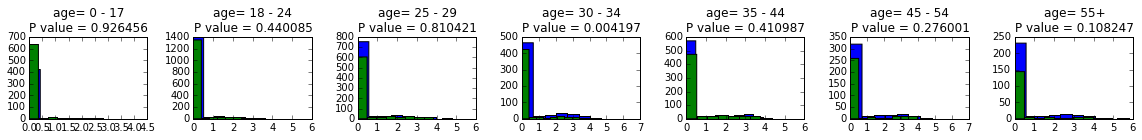

In [11]:
''' compare if different genders could be a factor for users' groups '''
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pyplot as plt
%matplotlib inline

users = pd.read_csv('listen_users_info.csv')
male = users[users['gender'].isin(['male'])]
female = users[users['gender'].isin(['female'])]
age = ['0 - 17', '18 - 24', '25 - 29', '30 - 34', '35 - 44', '45 - 54', '55+']

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16,2))
ax0, ax1, ax2, ax3, ax4, ax5, ax6 = axes.flat

x1 = list()  ## <= x1: male
x2 = list()  ## <= x2: female
for i in range(len(age)):
    x1 = male[male['age'].isin([age[i]])]['avg_paid_time'].tolist()
    x2 = female[female['age'].isin([age[i]])]['avg_paid_time'].tolist()
    p_value = P_value(x1, x2)
    histPlot(i, ax0, ax1, ax2, ax3, ax4, ax5, ax6, x1, x2, p_value)
    
plt.tight_layout()
plt.show()

The above results separate different age ranges as different groups, and compare the male and female user distributions for each group. We can see neither the age group has small P-value, all larger than 0.05 (for 95% confidence). This shows that we are unable to reject the null hypothesis for any ages. In other words, either the group X(m) and X(f) have same behavior, or the sample we test here does not show this indication. The users' (who paid to listen music) gender is not an important impact based on the current data.


### 2) The users' habits on different ages

This subsection analyzes users' habit for different ages. We first examine the users' listening habits (considering both free and paid music) for different ages:

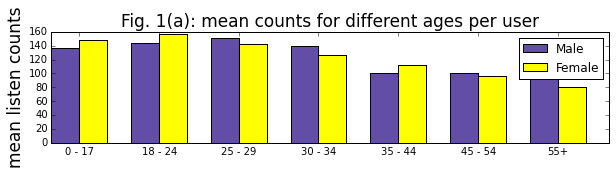

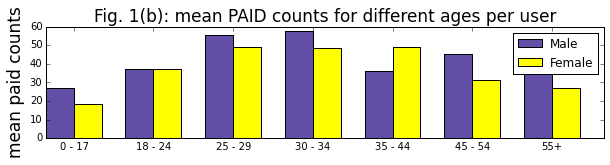

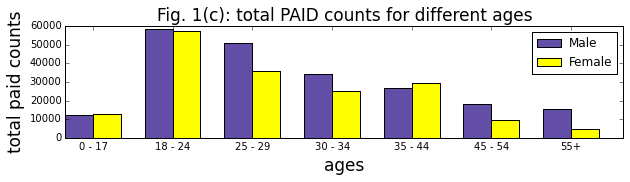

In [13]:
'''Analysis between the overall and paid COUNT for different ages and genders '''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

users = pd.read_csv('listen_users_info.csv')
male = users[users['gender'].isin(['male'])]
female = users[users['gender'].isin(['female'])]
age = ['0 - 17', '18 - 24', '25 - 29', '30 - 34', '35 - 44', '45 - 54', '55+']
itemType = ['count', 'paid_count']

ind = np.arange(len(age))
width = 0.35
plotLengend = ['Male', 'Female']
size = (10, 2)
for item in itemType:
    menMeans = list()
    womenMeans = list()
    for i in range(len(age)):
        male_age = male[male['age'].isin([age[i]])][item]
        menMeans.append(np.mean(male_age))
        female_age = female[female['age'].isin([age[i]])][item]
        womenMeans.append(np.mean(female_age))
    
    if item == 'count': 
        barPlot(size, age, menMeans, womenMeans, '#624ea7', 'yellow', '', 'mean listen counts',\
           "Fig. 1(a): mean counts for different ages per user", plotLengend)
    elif item == 'paid_count':
        barPlot(size, age, menMeans, womenMeans, '#624ea7', 'yellow', '', 'mean paid counts',\
           "Fig. 1(b): mean PAID counts for different ages per user", plotLengend)

menSums = list()
womenSums = list()
for i in range(len(age)):
    male_age = male[male['age'].isin([age[i]])]['paid_count']
    menSums.append(np.sum(male_age))
    female_age = female[female['age'].isin([age[i]])]['paid_count']
    womenSums.append(np.sum(female_age))
    
barPlot(size, age, menSums, womenSums, '#624ea7', 'yellow', 'ages', 'total paid counts',\
           "Fig. 1(c): total PAID counts for different ages", plotLengend)

The above figures show the averaged situation of users' total listening counts and paid counts for each age group and different genders. The "mean listen counts" = (total number of times to visit the music web)/(number of users of the group), and "mean paid counts" = (number of times to PAY to visit the music web)/(number of users of the group). In Fig. 1(a), we can roughly see that for teenagers, irrespective of genders, and younger people ('18-24' and '25-29') visited the web more frequently than the older age group. (Keep in mind that the error bars could be big. See figures in Sec. App.) But Fig. 1(b) shows the younger people, in particular the group of '0-17', are less frequent to pay to listen the music. In this group, most users are students and unable to afford the charge.

But for the age groups = '18-24' and '25-29', the paid counts increase. They can be explained that the users of these groups have more economic capability of paying to listen music. Part of users in these ages start to work and are able to afford it. But in the older group, e.g. ages > '35-44', the users become less frequent to listen music with/without paying again. Some of the users may have family and have to consider to save money. Interesting, in the elder group, e.g. '45-54' and '55+', the male users have higher preference to pay listening music than the female users do.

However, the numbers of users in each age group are very different. Fig. 1(c) reveals the total number of paid counts for each group. We can see now the age of '18-24' contributes most counts among all the ages. Hence, if the music compnay charges the fee based on the number of times to visit the music web, then the age groups '18-24' and '25-29' are best potential customers.

Next let us see the analysis based on the mean listening time length for each group.

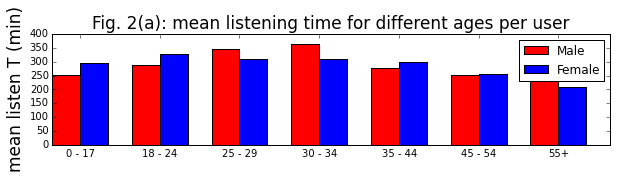

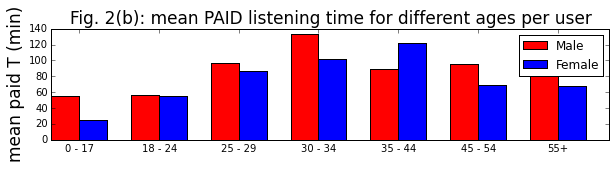

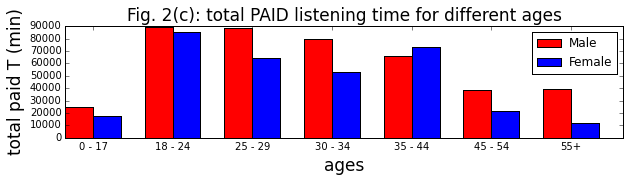

In [14]:
'''Analysis between the overall and paid mean LISTENING TIME for different ages and genders '''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

itemType = ['time', 'paid_time']

ind = np.arange(len(age))
width = 0.35
plotLengend = ['Male', 'Female']
size = (10, 2)
for item in itemType:
    menMeans = list()
    womenMeans = list()
    for i in range(len(age)):
        male_age = male[male['age'].isin([age[i]])][item]
        menMeans.append(np.mean(male_age))
        female_age = female[female['age'].isin([age[i]])][item]
        womenMeans.append(np.mean(female_age))

    if item == 'time': 
        barPlot(size, age, menMeans, womenMeans, 'r', 'b', '', 'mean listen T (min)',\
           "Fig. 2(a): mean listening time for different ages per user", plotLengend)
    elif item == 'paid_time':
        #print ('ok')
        barPlot(size, age, menMeans, womenMeans, 'r', 'b', '', 'mean paid T (min)',\
           "Fig. 2(b): mean PAID listening time for different ages per user", plotLengend)

menSums = list()
womenSums = list()
for i in range(len(age)):
    male_age = male[male['age'].isin([age[i]])]['paid_time']
    menSums.append(np.sum(male_age))
    female_age = female[female['age'].isin([age[i]])]['paid_time']
    womenSums.append(np.sum(female_age))

barPlot(size, age, menSums, womenSums, 'r', 'b', 'ages', 'total paid T (min)',\
           "Fig. 2(c): total PAID listening time for different ages", plotLengend)

Rather than mean listening counts, the above figures show the comparison of users' total mean listening time length (per user), mean paid time length (per suer) and total listening time length for each age group and different genders. The units are minutes.

"mean listen T (time)" is defined as the averages of (total listen times)/(total number of listen counts) per user, and "mean paid T" defined as averages of (paid times length)/(number of paid counts) per user. Fig. 2(a) shows that the users on ages of '25-29' and '30-34' still spent slightly more time to listen music than other groups. (Keep in mind that the error bars could be big. See figures in Sec. App.)

Meanwhile, Fig. 2(b) still shows the younger people, age groups = '0-17' and '18-24', have less preference to pay listening the music, similar to the count plot in Fig. 1(b). But older users have higher preference to pay. Beyond ages of '30-34', all the users have approximately similar behavior to pay listening music (but still, males have higher preference to pay music than females).

Although the age group of '18-24' seems to have lower "mean paid time", but there are more users in the group than others. Hence this group also contributes significant paid time to the company. Fig. 2(c) considers the "total paid T" for each group (not per user). We still see that the total paid time length of the age group '18-24' is comparable to the groups '25-29' and is significantly more than other groups. Obviously, the company hardly earns money from the teenagers '0-17'.
 
In conclusion, even if the compnay charges the fee based on the listening times length (like 1 min 1 dollar), the age group '18-24', '25-29' are still important potential users. The group of '30-34' and '35-44' have similar habits for the compnay's business but less significant expense than '18-24' and '25-29'. For the teenagers and elder groups, the users obviously have less preference to pay music.

Netx, we further compare if the age groups are different from each other, using statistical viewpoint and computing P-value.

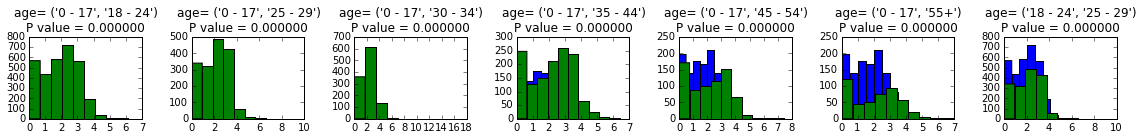

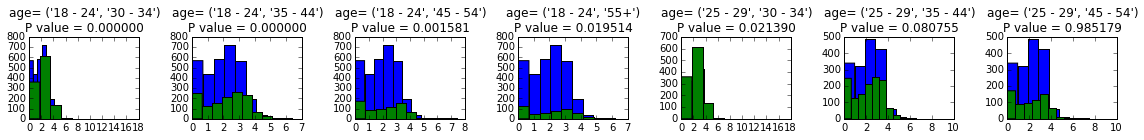

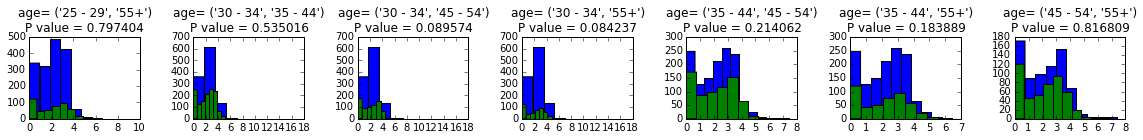

In [15]:
''' compare if the ages could be a factor for the users' groups'''
users = pd.read_csv('listen_users_info.csv')

ages = [[('0 - 17', '18 - 24'), ('0 - 17', '25 - 29'), ('0 - 17', '30 - 34'), ('0 - 17', '35 - 44'),\
         ('0 - 17', '45 - 54'), ('0 - 17', '55+'), ('18 - 24', '25 - 29')],
        [('18 - 24', '30 - 34'), ('18 - 24', '35 - 44'), ('18 - 24', '45 - 54'),('18 - 24', '55+'),\
         ('25 - 29', '30 - 34'), ('25 - 29', '35 - 44'), ('25 - 29', '45 - 54')],
        [('25 - 29', '55+'), ('30 - 34', '35 - 44'), ('30 - 34', '45 - 54'), ('30 - 34', '55+'),\
         ('35 - 44', '45 - 54'), ('35 - 44', '55+'), ('45 - 54', '55+')]]
        
for age in ages:
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16,2))
    ax0, ax1, ax2, ax3, ax4, ax5, ax6 = axes.flat
    for i in range(len(age)):
        x1 = users[users['age'].isin([age[i][0]])]['avg_listen_time'].tolist()  ## x1: group age_1
        x2 = users[users['age'].isin([age[i][1]])]['avg_listen_time'].tolist()  ## x2: group age_2
        p_value = P_value(x1, x2)
        histPlot(i, ax0, ax1, ax2, ax3, ax4, ax5, ax6, x1, x2, p_value)
    plt.tight_layout()
    
plt.show()

We first analyze the users' total listen time distribution. There are 7 age groups '0-17', '18-24'... and '55+', so there are 7x6/2 =21 pairwise group comparisons. The above shows 21 pairwise two-sample tests and the histgrams of  X(age1) and X(age2). For each test, we have the null hypothesis:

  H0: X(age1) = X(age2) 
  
and the alternative hypothesis is X(age1) != X(age2).

We can see three points:
(1) The ages of '0-17' and '18-24' are different from any other groups. The P-values between these two groups and any    
    other else are smaller than 0.05. Hence we can have 95 % confidence to reject the null hypothesis, i.e. ages '0-
    17' and '18-24' are NOT similar to any others.
(2) The null hypothesis X('0-17') = X('18-24') can be rejected.
(3) For any two ages beyond '25-29', we are unable to reject the null hypothesis X(age1) = X(age2), for age1 and age2 
    > '25'. Either these age groups are similar to each other or the current samples do not show the indication.

From those, we can roughly say that the group of '0-17' and '18-24' are different from other age groups, and '0-17' and '18-24' seem to be different from each other. Next let us see the users' paid listen time distribution.

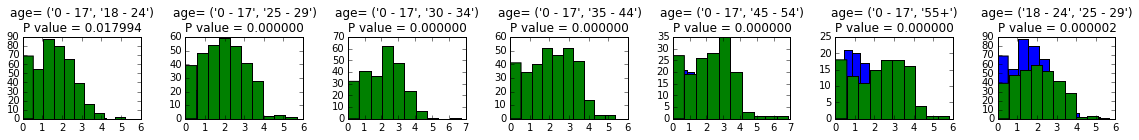

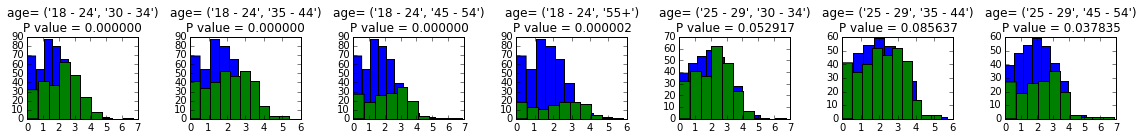

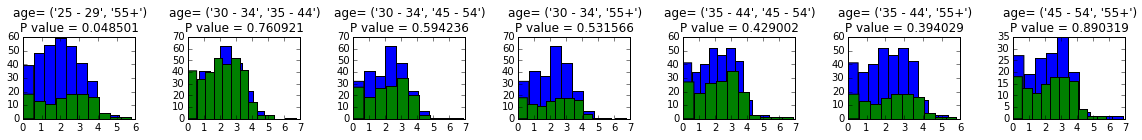

In [16]:
''' now analyze adjusted results, to focus our discussion droping users who didn't paid '''
for age in ages:
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16,2))
    ax0, ax1, ax2, ax3, ax4, ax5, ax6 = axes.flat
    for i in range(len(age)):
        x1 = users[users['age'].isin([age[i][0]])]['avg_paid_time'].tolist()  ## x1: group age_1
        x2 = users[users['age'].isin([age[i][1]])]['avg_paid_time'].tolist()  ## x2: group age_2
        adjusted_x1 = list()  ## <= adjusted_x1: adjusted group age_1
        for j in range(len(x1)):
            if x1[j] !=0: adjusted_x1.append(x1[j])

        adjusted_x2 = list()  ## <= adjusted_x2: adjusted group age_2
        for j in range(len(x2)):
            if x2[j] !=0: adjusted_x2.append(x2[j])

        p_value = P_value(adjusted_x1, adjusted_x2)
        histPlot(i, ax0, ax1, ax2, ax3, ax4, ax5, ax6, adjusted_x1, adjusted_x2, p_value)
    plt.tight_layout()
    
plt.show()

The above show 21 pairwise two-sample tests and the histgrams of X(age1) and X(age2), where the distribution is about the "mean paid time". But note that for the mean paid time histgram, we have a majority on paid time =0. To focus on the users who paid, we drop the users who didn't pay at all. 

For each pairwise test, we still have the null hypothesis:

  H0: X(age1) = X(age2) 
  
and the alternative hypothesis is X(age1) != X(age2).

We can see four points:
(1) The age of '0-17' and '18-24' are still different from any other groups. Hence we can have 95 % confidence to reject the null hypothesis, i.e. for paid habit, age groups of '0-17' and '18-24' are NOT similar to any others.

(2) The null hypothesis X('0-17') = X('18-24') can still be rejected.

(3) The age group of '25-29' is marginal, meaning that we cannot make any conclusion. We can see the P-values of the 
    half of X('25-29') and X(ages) are lager than 0.05, and the other half is smaller than 0.05.
    
(4) For the ages beyond '30-34', we are unable to reject the null hypothesis X(age1) = X(age2) for age1, age2 >= '30'.

Combined these (only considering ages and genders), we can cluster the paid users as 2 categories: regard the age group of '0-17' and '18-24' as category A, and age > '25' as category B. Or cluster the users as 3 categories: regard '0-17' as category A, age = '18-24' as category B, and age >= '25' as category C etc.

### 3) The users' habits on different countries
This subsection is to analyze the user distribution on different countries. The country names are labeled by the short, see https://countrycode.org/ for full country names.

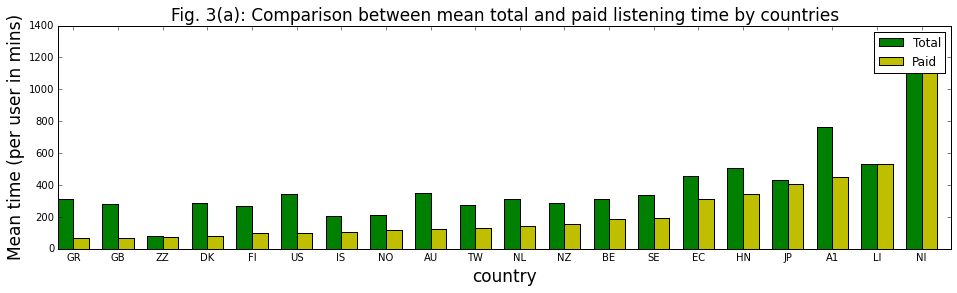

In [17]:
'''Analysis between the overall and paid LISTENING TIME for different countries'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

users = pd.read_csv('listen_users_info.csv')
country = O.country

country = list()
totalTime = list()
paidTime = list()
for ch in O.country:
    country.append(ch)
    localUsers = users[users['country'].isin([ch])]
    totalTime.append(np.mean(localUsers['time'].tolist()))
    paidTime.append(np.mean(localUsers['paid_time'].tolist()))

v = sorted(range(len(paidTime)), key=lambda k: paidTime[k])
sorted_paidTime = [paidTime[i] for i in v]
sorted_totalTime = [totalTime[i] for i in v]
sorted_country = [country[i] for i in v]

barPlot((16, 4), sorted_country[49:], sorted_totalTime[49:], sorted_paidTime[49:], 'g', 'y', 'country',\
        'Mean time (per user in mins)', "Fig. 3(a): Comparison between mean total and paid listening time by countries",\
        ('Total', 'Paid'))

Fig. 3(a) shows the mean listening time length and mean paid time length for each country. (Keep in mind that the error bars could be big.) The green bars denote the mean "Total", the "mean listening time length" = (total listening time in the country)/(number of users in the country); the yellow bars denote "Paid", the "mean paid time length" = (paid time in the country)/(the number of users in the country). The result seems the top rank country to contribute largest "mean listening time length" is "NI", Nicaragua, and seond one is "LI", Liechtenstein, and US's rank is at 15th. However, the indication is misleading. If we further examine the number of users for the Top-15 countries:

In [18]:
ii =0
for i in range(len(sorted_country)-1,53,-1):
    ii += 1
    print (ii, sorted_country[i], len(O.country[country[v[i]]]))

1 NI 4
2 LI 1
3 A1 2
4 JP 2
5 HN 9
6 EC 28
7 SE 271
8 BE 86
9 NZ 63
10 NL 255
11 TW 51
12 AU 216
13 NO 114
14 IS 12
15 US 3147


We can find the the number of users from US is the largest, whereas NI and LI have few users only. Statistically the results on NI and LI are not trustable. To be more clear, we show the chart for total "listening time length" and "paid time length", not per user in Fig. 3(b) below:

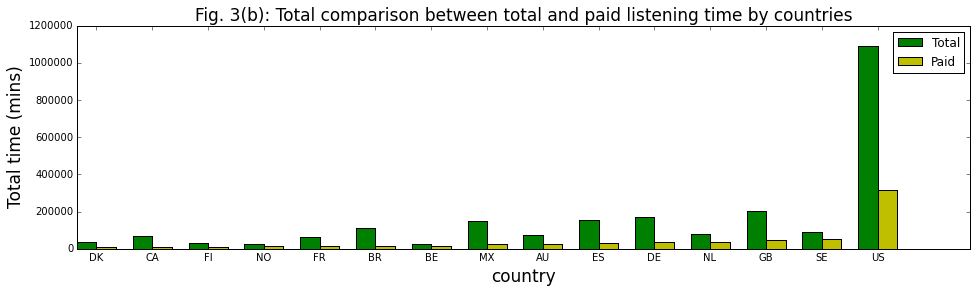

In [19]:
totalTime = list()
paidTime = list()
country[:] = sorted_country[:] 
for i in range(len(sorted_country)):
    number_users = len(O.country[country[i]])
    totalTime.append(sorted_totalTime[i]*number_users)
    paidTime.append(sorted_paidTime[i]*number_users)

v = sorted(range(len(paidTime)), key=lambda k: paidTime[k])
sorted_paidTime = [paidTime[i] for i in v]
sorted_totalTime = [totalTime[i] for i in v]
sorted_country = [country[i] for i in v]

barPlot((16, 4), sorted_country[54:], sorted_totalTime[54:], sorted_paidTime[54:], 'g', 'y', 'country',\
        'Total time (mins)', "Fig. 3(b): Total comparison between total and paid listening time by countries",\
        ('Total', 'Paid'))

We can see that the users from US significantly contribute the listen and paid time, due to the large number of users. The second and third largest markets are "SE"= "Sweden" and "GB"= "United Kindom", and the followings are NL: Netherlands, "DE": "Germany".... etc, which are all advanced countries. This shows that business in US is still important.


### 4) Clustering

This subsection performs the K-means to group the users and see if we can have any insight from clustering. Let us first make two dimensional scatter plot in Fig. 4(a): X = mean listen time, and Y= mean paid time. Each point denotes a user. The color labels the users' ages: '0-17', '18-24'....

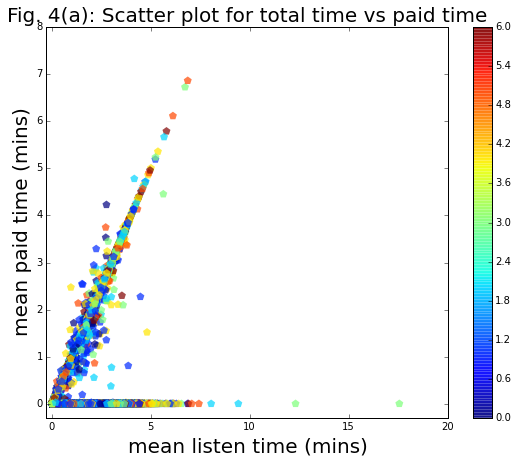

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

users = pd.read_csv('listen_users_info.csv')
age = {'0 - 17': 0, '18 - 24': 1, '25 - 29': 2, '30 - 34': 3, '35 - 44': 4, '45 - 54': 5, '55+': 6}

x1 = list()  ## <= x1: avg_listen_time
x2 = list()  ## <= x2: avg_paid_time
y = list()   ## <=  y: age 

x1 = users['avg_listen_time'].tolist()
x2 = users['avg_paid_time'].tolist()
y = users['age'].tolist()
for i in range(len(y)):
        y[i] = float(age[y[i]])

scatterPlot((9,7), x1, x2, y, 'Fig. 4(a): Scatter plot for total time vs paid time')
plt.show()

From the results, we can observe some interesting features:

(1) The users can be roughly grouped two categories: people who "like paid" and "like free", we call group A and B by two obvious straight lines, Y=0 and Y = X. The former denotes the users who prefer to pay listening music, whereas the latter shows the users who prefer to listen free music.

  (Note that some data points are located at y > x. The definition of 'mean listen time' = (total listen time    
   length)/(total listen counts) and 'mean listen time' = (paid time length)/(paid counts). As an example, the user    
   whose ID is '2934a4ee916749969909cd19930c9910':

male,25 - 29,AU,111,102.63001666666668,0.9245947447447448,66,80.83223333333333,1.2247308080808081,1.324613637533623

   This '25-29' years old male user (from Australia) totally visited the music web 111 times, and spent 102 mins to      listen; among the time, he paid 66 times with 80 mins. Therefore, in average, the user has y = 1.2247 but x =  
   0.9246; then y > x, but actually still did not pay more than he used.)

(2) The second feature is about the line Y=X. We can observe most observations in the group A are located near Y=X. This suggests that, the users of the group A prefer to pay most music listening, rather than selecting songs to pay.

(3) The third feature is that along the line Y=X, we see the blue points are roughly located at small listen time and  
paid time (X, Y < 4 mins). This is consistent with Fig. 2(a,b), where the younger people ('0-17' and '18-24') have 
less mean listen and paid time. However, the users from other age groups (age >'25-29',....) do not have any obvious preference for mean listen time. We can the green, yellow and orange colors distribute over all ranges of listen time.
    
    
Next we try to perform K-mean to see how much insight we can obtain from the clustering method. Again, we focus on the users who paid to listen music, i.e. group A. To do it, we make adjustment on X and Y for paid users:

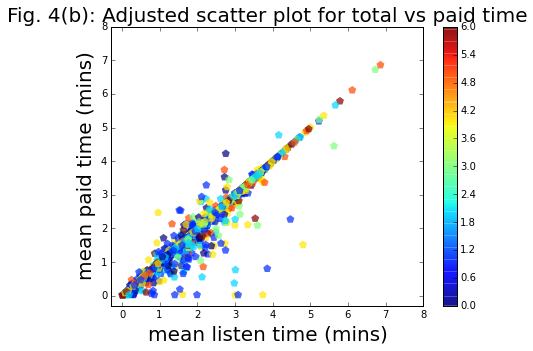

In [23]:
''' now analyze adjusted results, to focus our discussion droping users who didn't paid '''

adjusted_x1 = list()  ## <= x1: avg_listen_time
adjusted_x2 = list()  ## <= x2: avg_paid_time
adjusted_y = list()   ## <=  y: age 
for i in range(len(y)):
    if x2[i] != 0:
        adjusted_x1.append(x1[i])
        adjusted_x2.append(x2[i])
        adjusted_y.append(y[i])

scatterPlot((7,5), adjusted_x1, adjusted_x2, adjusted_y, 'Fig. 4(b): Adjusted scatter plot for total vs paid time')
plt.show()

Fig. 4(b) uses the adjusted data: the data only having the users who paid to listen music. Next we use Scikit-learn to perform K-means, and try to obatin insight from the users. We consider three different clustering strategies: 2, 3 and 4 clusters, corresponding to K=2, 3, and 4 in K-means. 

(1) The first one denotes age '0-17' and '18-24' as category A, and age > '25' as B:

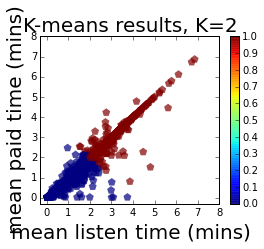

Best K = 2, accuracy = 0.587375803623612 , SED =  1.79913649978


In [24]:
''' K-means with K=2''' 
from sklearn.cluster import KMeans

X = np.column_stack((adjusted_x1, adjusted_x2))

y2 = list()
for i in range(len(adjusted_y)):
    if adjusted_y[i] <= 1:
        y2.append(0)
    else:
        y2.append(1)

for trial in range(10):
    est = KMeans(n_clusters=2)
    est.fit(X)
    labels = est.labels_
    error = SED(2, adjusted_x1, adjusted_x2, labels)     
    accy = accucy(y2, labels)
    if trial == 0:
        best_error = error
        best_accy = accy
        best_est =est
    else:
        if error < best_error:
            best_error = error
            best_est = est
            best_accy = accy
    #print ('K = 2, accuracy =', accy, ', SED = ', error)        
            
scatterPlot((4,3), adjusted_x1, adjusted_x2, best_est.labels_.astype(np.float), 'K-means results, K=2')
plt.show()
print ('Best K = 2, accuracy =', best_accy, ', SED = ', best_error)

(2) The 3 cluster, regarding '0-17' as A, '18-24' as B and age > '25' as C:

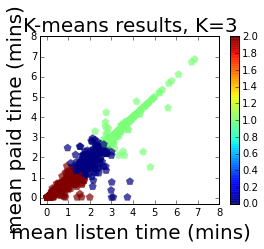

Best K = 3, accuracy = 0.24371712448860317 , SED =  1.79645200006


In [25]:
''' K-means with K=3''' 
from sklearn.cluster import KMeans

X = np.column_stack((adjusted_x1, adjusted_x2))

y2 = list()
for i in range(len(adjusted_y)):
    if adjusted_y[i] <= 0:
        y2.append(0)
    elif adjusted_y[i] == 1:
        y2.append(1)
    else:
        y2.append(2)

for trial in range(10):
    est = KMeans(n_clusters=3)
    est.fit(X)
    labels = est.labels_
    error = SED(3, adjusted_x1, adjusted_x2, labels)
    accy = accucy(y2, labels)
    if trial == 0:
        best_error = error
        best_accy = accy
        best_est =est
    else:
        #print (error, best_error)
        if error < best_error:
            best_error = error
            best_est = est
            best_accy = accy

scatterPlot((4,3), adjusted_x1, adjusted_x2, best_est.labels_.astype(np.float), 'K-means results, K=3')
plt.show()
print ('Best K = 3, accuracy =', best_accy, ', SED = ', best_error)

(3) The 4 cluster, regarding '0-17' as A, '18-24' as B, '25-29' as C and age > '30' as D:

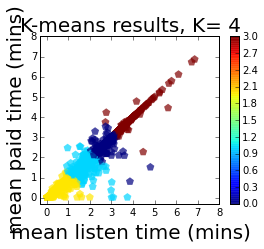

Best K = 4, accuracy = 0.2711864406779661 , SED =  1.81120244829


In [26]:
''' K-means with K=4''' 
from sklearn.cluster import KMeans

X = np.column_stack((adjusted_x1, adjusted_x2))

y2 = list()
for i in range(len(adjusted_y)):
    if adjusted_y[i] == 0:
        y2.append(0)
    elif adjusted_y[i] == 1:
        y2.append(1)
    elif adjusted_y[i] == 2:
        y2.append(2)    
    else:
        y2.append(3)   

for trial in range(10):
    est = KMeans(n_clusters=4)
    est.fit(X)
    labels = est.labels_
    error = SED(4, adjusted_x1, adjusted_x2, labels)
    accy = accucy(y2, labels)
    if trial == 0:
        best_error = error
        best_accy = accy
        best_est =est
    else:
        if error < best_error:
            best_error = error
            best_est = est
            best_accy = accy

scatterPlot((4,3), adjusted_x1, adjusted_x2, best_est.labels_.astype(np.float), 'K-means results, K= 4')
plt.show()
print ('Best K = 4, accuracy =', best_accy, ', SED = ', best_error)

Among the K=2,3,4 results, K=2 give the best estimation; lowest mean squared Euclidean distance (SED) and higher accuracy. For each K, the shown outcome has been run using 10 trials to select the lowest SED error. 

'K=2' is roughly consistent with the previous analysis. Recalled that we had two-sample test, and rejected the hypothesis -- the age groups of '0-17' and '18-24' are the same to others. Thus these age groups of '0-17' and '18-24' are statistically different from the age groups of age > '25'. For the users who paid to listen music, we can cluster the ages of '0-17' and '18-24' as group A, and the age > '25' as group B. However, the accuracy is not good, only 50% compared to real data. Thus there may exist other factors for more obvious categories.

## (C) Songs' data anlysis

In this section, we explore which songs are popular among the users? What are the users' ages, and what is the fraction among the users who would like to pay to listen music, and any other insight?

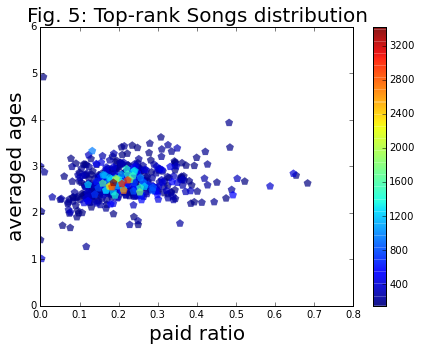

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

age = {'0 - 17': 1, '18 - 24': 2, '25 - 29': 3, '30 - 34': 4, '35 - 44': 5, '45 - 54': 6, '55+': 7, '': 0}

x1 = list()
x2 = list()
x3 = list()
songs_gender = list()
songs_us = list()
names = list()
y = list()
for song in O.songs:
    users = O.songs[song][0]         ## <= user list, a list
    listen_time = O.songs[song][1]   ## <= listen time
    paid_time = O.songs[song][2]     ## <= paid time
    users_ages = list()
    gender_ct = 0
    us_ct =0
    country_name = dict()
    for user in users:                            ## <= find out the users' ages from the user list 
        users_ages.append(age[O.users[user][1]])
        if O.users[user][0] == 'male': gender_ct += 1
        if O.users[user][2] == 'US': us_ct += 1
        if O.users[user][2] not in country_name:
            country_name[O.users[user][2]] = 1
        else:
            country_name[O.users[user][2]] += 1
    names.append(song)
    x1.append(paid_time/listen_time)              ## <= paid ratio
    x2.append(np.mean(users_ages))                ## <= averaged ages
    x3.append(paid_time)
    songs_gender.append(float(gender_ct)/len(O.songs[song][0]))
    songs_us.append(float(us_ct)/len(O.songs[song][0]))
    y.append(float(len(O.songs[song][0])))   ## <= number of users for this song

v = sorted(range(len(y)), key=lambda k: y[k])
sorted_x1 = [x1[i] for i in v]
sorted_x2 = [x2[i] for i in v]
sorted_x3 = [x3[i] for i in v]
sorted_y = [y[i] for i in v]
sorted_names = [names[i] for i in v]

fig, ax = plt.subplots(figsize=(7,5))
s = ax.scatter(sorted_x1[len(x1)-500:], sorted_x2[len(x1)-500:], s=70, c=sorted_y[len(x1)-500:],\
               marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
plt.colorbar(mappable=s, ax=ax)
ax.set_xlabel('paid ratio', size=20)
ax.set_ylabel('averaged ages', size=20)
ax.set_title('Fig. 5: Top-rank Songs distribution', size=20)
plt.xlim(0,)
plt.ylim(0,)
plt.show()

Fig. 5 shows the Top-500 popular songs in terms of X= "paid ratio" = (users' paid time on this song)/(users' total listen time on this song) and Y= "averaged ages" = (all user's ages)/(the number of users who listened the song). In the scatter plot, each point denotes a song, which can be visited by many users. Here we designate the ages '0-17'=1, '18-24'=2 as numbers... We see an interesting feature: the popular songs (green, yellow, orange and red points) are mostly located at X ~ 0.2 and 2 < Y < 3. The value of the averaged ages 2 < Y < 3 represents, that the users who listened the popular music are mostly between '18-24' and '25-30' years old. This reflects the dominating users for the popular songs are young people, c.f. Fig. 1(c) and Fig. 2(c).

From Fig. 5, it is difficult to visualize clustering between the popular songs and others, based on "paid ratio" and "averaged ages" only. Next we try to search any other possible features which could be helpful to distinguish the top-rank songs and others.

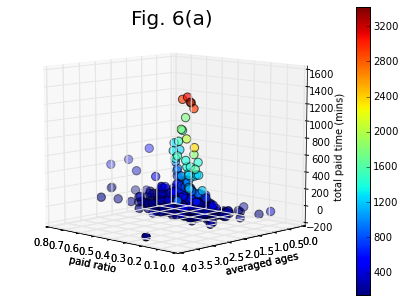

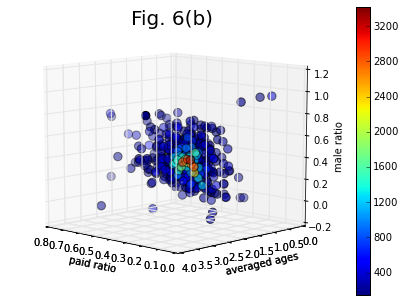

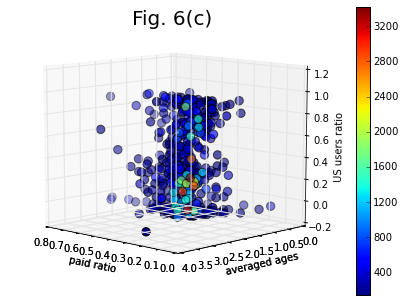

In [28]:
Scatter3Dplot(sorted_x1[len(x1)-500:], sorted_x2[len(x1)-500:], sorted_x3[len(x1)-500:],\
              sorted_y[len(x1)-500:], 'paid ratio','averaged ages', 'total paid time (mins)', 'Fig. 6(a)')

cut_x1 = sorted_x1[len(sorted_x1)-1000:]
cut_x2 = sorted_x2[len(sorted_x2)-1000:]
cut_x3 = sorted_x3[len(sorted_x3)-1000:]
cut_y = sorted_y[len(sorted_y)-1000:]
## which cut vectors are going to use later.

x3 = list()
x3[:] = songs_gender[:]
sorted_x3 = [x3[i] for i in v]
Scatter3Dplot(sorted_x1[len(x1)-500:], sorted_x2[len(x1)-500:], sorted_x3[len(x1)-500:],\
              sorted_y[len(x1)-500:], 'paid ratio','averaged ages', 'male ratio', 'Fig. 6(b)')

x3[:] = songs_us[:]
sorted_x3 = [x3[i] for i in v]
Scatter3Dplot(sorted_x1[len(x1)-500:], sorted_x2[len(x1)-500:], sorted_x3[len(x1)-500:],\
              sorted_y[len(x1)-500:], 'paid ratio','averaged ages', 'US users ratio', 'Fig. 6(c)')

Fig. 6(a) shows the third feature as "total paid time". This plot shows that although the "paid ratio" is about 0.2, but users would be happy to pay listening the popular music. We can see that the top-rank songs (with colorful points) are roughly separate to others (blue dots). This suggests that with the total paid time, we can cluster "popular songes" as group A and "less popular songs" as group B.

What else factors from users can be important to cluster the popular songs? Fig. 6(b) uses "male ratio", i.e. (number of male users for the song)/(total number of users for the song) as the third feature. We can still designate "male"=1, and "female"=0. The male ratio ~0.5 suggests that the popular songs are netural; niether male or female prefer to listen to the songs. Fig. 6(b) shows "US users ratio" among the popular songs. But this feature is still not helpful for the clustering.

Next we implement K-means for K=2 to cluster "top-popular songs" and "others":

K = 2, accuracy = 0.869 , SED =  51.949006725


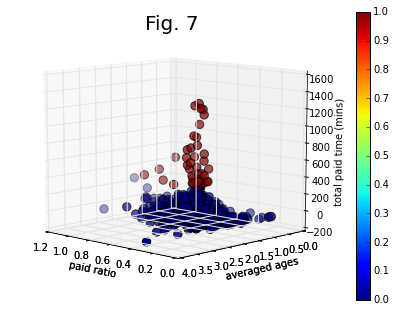

In [29]:
''' K-means with K=2''' 
from sklearn.cluster import KMeans

X = np.column_stack((cut_x1, cut_x2, cut_x3))

y2 = list()
for i in range(len(cut_y)):    
    if cut_y[i] <= 300:
        y2.append(0)
    else:
        y2.append(1)

for trial in range(1):
    est = KMeans(n_clusters=2)
    est.fit(X)
    labels = est.labels_
    error = SED3D(2, cut_x1, cut_x2, cut_x3, labels) 
    ## if keep all samples (sorted_x), there are 305857 so it will take a lot time to calculate mean distance!
    ## with cut samples (cut_x1), it is doable and much faster
    accy = accucy(y2, labels)
    if trial == 0:
        best_error = error
        best_accy = accy
        best_est =est
    else:
        #print (error, best_error)
        if error < best_error:
            best_error = error
            best_est = est
            best_accy = accy
    print ('K = 2, accuracy =', accy, ', SED = ', error)
    
Scatter3Dplot(cut_x1, cut_x2, cut_x3, est.labels_.astype(np.float), 'paid ratio','averaged ages',\
              'total paid time (mins)', 'Fig. 7')
plt.show()

Above is the K-means results with K=2, clustering Group A indicated by brown points and Group B by dark blue points.
Then we can quantitively examine the K-Means accuracy. We designate the "popular songs" which have been listened by more than 200 users as Group A; below the number, the songs belong to Group B. By this selection, the K-means accuracy is 0.73. 

Thus, we can roughly cluster the songs as Group A: the users' paid time >= 200 mins, these songs have the number of users > 1200. Others are Group B. But keep in mind that the selection of 200 users as the boundary to clutser may be biased. If we chose the bar, the number of user as 300, the accuracy could be 0.87.

## (D) Summary

Based on the data, we can have following summary:

(1) The users on the age of '18-24' and '25-29' are potentially important. These groups significantly contribute the music business due to the number of users (c.f. Fig. 1(c) and Fig. 2(c)).

(2) Statistically, the groups of age on '0-17' and '18-24' have different paid habits from the other ages group from two-sample test. This can be also supported using K-means with K=2, clustering as two groups. IN AVERAGE, they do not like to spend money to music.

(3) Fig. 4(a) shows that the users either have habit to pay listening most music, or would like to enjoy free music without paying. These are extreme cases.

(4) Fig. 3(b) shows that US has the largest potential market.

(5) From Fig. 6(a), for the popular songs, although users are mostly young people, they prefer to pay money once they enjoy the music. 

## Appendix

The following boxplots show that the mean values in the previous sections (indictaed in Fig. 1, 2, and 3) have large error bar. This is for visualization reference.

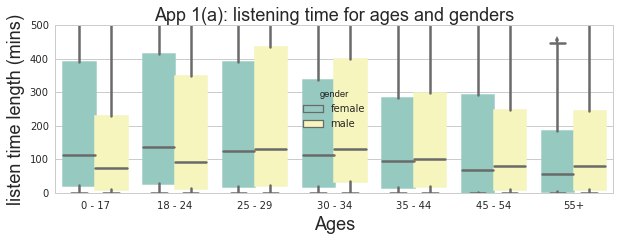

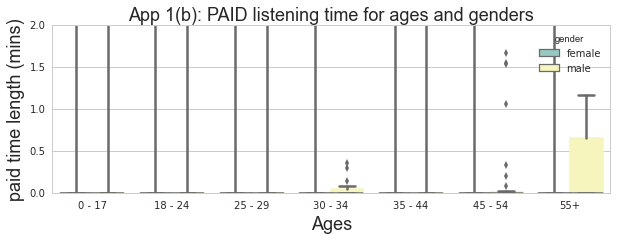

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

users = pd.read_csv('listen_users_info.csv')
sorted_users = users.sort('age',ascending=True)

sns.set_style("whitegrid")

fig1, ax1 = plt.subplots(figsize=(10, 3))
ax1 = sns.boxplot(x="age", y="time", hue="gender", data=sorted_users, palette="Set3", linewidth=2.5)
ax1.set_xlabel('Ages', size=18)
ax1.set_ylabel('listen time length (mins)', size=18)
ax1.set_title('App 1(a): listening time for ages and genders', size=18)
plt.ylim(0,500)


fig1, ax1 = plt.subplots(figsize=(10, 3))
ax1 = sns.boxplot(x="age", y="paid_time", hue="gender", data=sorted_users, palette="Set3", linewidth=2.5)
ax1.set_xlabel('Ages', size=18)
ax1.set_ylabel('paid time length (mins)', size=18)
ax1.set_title('App 1(b): PAID listening time for ages and genders', size=18)

plt.ylim(0,2)
plt.show()